In [12]:
import gymnasium as gym
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torchvision.transforms as T
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import random
import math
import pickle
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
def image_preprocessing(img):
  img = cv2.resize(img, dsize=(84, 84))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
  return img

In [14]:
class CarEnvironment(gym.Wrapper):
  def __init__(self, env, skip_frames=2, stack_frames=4, no_operation=5, **kwargs):
    super().__init__(env, **kwargs)
    self._no_operation = no_operation
    self._skip_frames = skip_frames
    self._stack_frames = stack_frames

  def reset(self):
    observation, info = self.env.reset()

    for i in range(self._no_operation):
      observation, reward, terminated, truncated, info = self.env.step(0)

    observation = image_preprocessing(observation)
    self.stack_state = np.tile(observation, (self._stack_frames, 1, 1))
    return self.stack_state, info


  def step(self, action):
    total_reward = 0
    for i in range(self._skip_frames):
      observation, reward, terminated, truncated, info = self.env.step(action)
      total_reward += reward
      if terminated or truncated:
        break

    observation = image_preprocessing(observation)
    self.stack_state = np.concatenate((self.stack_state[1:], observation[np.newaxis]), axis=0)
    return self.stack_state, total_reward, terminated, truncated, info

In [15]:
class CNN(nn.Module):
  def __init__(self, in_channels, out_channels, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self._n_features = 32 * 9 * 9

    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, 16, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=4, stride=2),
        nn.ReLU(),
    )

    self.fc = nn.Sequential(
        nn.Linear(self._n_features, 256),
        nn.ReLU(),
        nn.Linear(256, out_channels),
    )


  def forward(self, x):
    x = self.conv(x)
    x = x.view((-1, self._n_features))
    x = self.fc(x)
    return x

In [16]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [17]:
class DQN:
  def __init__(self, action_space, batch_size=256, gamma=0.99, eps_start=0.9, eps_end=0.05, eps_decay=1000, lr=0.001, use_vit=False):
      self._n_observation = 4
      self._n_actions = 5
      self._action_space = action_space
      self._batch_size = batch_size
      self._gamma = gamma
      self._eps_start = eps_start
      self._eps_end = eps_end
      self._eps_decay = eps_decay
      self._lr = lr
      self._total_steps = 0
      self._evaluate_loss = []
      self.use_vit = use_vit  
      
      # 네트워크 초기화
      self.network = self.build_network()
      self.target_network = self.build_network()
      self.target_network.load_state_dict(self.network.state_dict())
      self.optimizer = optim.AdamW(self.network.parameters(), lr=self._lr, amsgrad=True)
      self._memory = ReplayMemory(10000)  
      
      # 초기 네트워크 파라미터 저장 (Shrink & Perturb용)
      self.initial_params = self.network.state_dict()  
      
  def build_network(self):
        if self.use_vit:
            # ViT 모델을 weights 매개변수를 사용하여 불러옴
            weights = ViT_B_16_Weights.DEFAULT
            model = vit_b_16(weights=weights)
            model.heads.head = nn.Linear(model.heads.head.in_features, self._n_actions)
            return model.to(device)
        else:
            return CNN(self._n_observation, self._n_actions).to(device)

  """
  This function is called during training & evaluation phase when the agent
  interact with the environment and needs to select an action.

  (1) Exploitation: This function feeds the neural network a state
  and then it selects the action with the highest Q-value.
  (2) Evaluation mode: This function feeds the neural network a state
  and then it selects the action with the highest Q'-value.
  (3) Exploration mode: It randomly selects an action through sampling

  Q -> network (policy)
  Q'-> target network (best policy)
  """
  def select_action(self, state, evaluation_phase=False):
    # Generating a random number for eploration vs exploitation
    sample = random.random()

    # Calculating the threshold - the more steps the less exploration we do
    eps_threshold = self._eps_end + (self._eps_start - self._eps_end) * math.exp(-1. * self._total_steps / self._eps_decay)
    self._total_steps += 1

    if evaluation_phase:
      with torch.no_grad():
        return self.target_network(state).max(1).indices.view(1, 1)
    elif sample > eps_threshold:
      with torch.no_grad():
        return self.network(state).max(1).indices.view(1, 1)
    else:
      return torch.tensor([[self._action_space.sample()]], device=device, dtype=torch.long)
        

  def train(self, replay_ratio=1):
    if len(self._memory) < self._batch_size:
        return
        
    for _ in range(replay_ratio):
        # Initializing our memory
        transitions = self._memory.sample(self._batch_size)
        # Initializing our batch
        batch = Transition(*zip(*transitions))
        
        # Saving in a new tensor all the indices of the states that are non terminal
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Feeding our Q network the batch with states and then we gather the Q values of the selected actions
        state_action_values = self.network(state_batch).gather(1, action_batch)
        
        # We then, for every state in the batch that is NOT final, we pass it in the target network to get the Q'-values and choose the max one
        next_state_values = torch.zeros(self._batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1).values

        # Computing the expecting values with: reward + gamma * max(Q')
        expected_state_action_values = (next_state_values * self._gamma) + reward_batch
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.network.parameters(), 100)
        self.optimizer.step()
        self._evaluate_loss.append(loss.item())
            
  def shrink_and_perturb(self, alpha=0.9):
    current_params = self.network.state_dict()
    perturbed_params = {k: alpha * current_params[k] + (1 - alpha) * self.initial_params[k] for k in current_params}
    self.network.load_state_dict(perturbed_params)
      
  def copy_weights(self):
    self.target_network.load_state_dict(self.network.state_dict())

  def get_loss(self):
    return self._evaluate_loss

  def load_model(self, version, i):
    self.target_network.load_state_dict(torch.load(f'model/{version}/model_weights_{i}.pth', map_location=device))

  def load_model(self, version, i):
    self.target_network.load_state_dict(torch.load(f'model/{version}/model_weights_{i}.pth', map_location=device))

In [18]:
def reset_envs_with_random_seeds(envs):
    """
    각 환경에 랜덤 시드를 설정하고 초기화.
    """
    new_seeds = [np.random.randint(1000) for _ in range(len(envs))]
    states = []
    for env, seed in zip(envs, new_seeds):
        env.np_random = np.random.default_rng(seed)  # 랜덤 시드 재설정
        state, _ = env.reset()  # 환경 초기화
        states.append(torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0))
    return states

In [20]:
# parameter
import yaml
# YAML 파일 읽기
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# 설정값 가져오기
training_params = config['training']
env_params = config['environment']

# 초기 시드 설정
np.random.seed(42)  # NumPy 랜덤 시드 고정
torch.manual_seed(42)  # PyTorch 랜덤 시드 고정

# 환경 및 파라미터 설정
env_count = env_params['env_count']
TU = training_params['TU']
TC = training_params['TC']
TR = training_params['TR']
map_reset_interval = training_params['map_reset_interval']
replay_ratio = training_params['replay_ratio']
episodes = training_params['episodes']
alpha = training_params['alpha']
save_point = training_params['save_point']

In [ ]:
# 병렬 환경 생성

envs = [CarEnvironment(gym.make('CarRacing-v2', continuous=False)) for _ in range(env_count)]  # 최초 환경 생성
agent = DQN(envs[0].action_space, use_vit=False)

rewards_per_episode = []
episode_duration = []
average_episode_loss = []
version=f"baseline_{map_reset_interval}_{replay_ratio}_{alpha}_{TU}_{TR}"

for episode in tqdm(range(1, episodes + 1), desc="Training"):

    # 특정 주기마다 맵 변경
    if episode % map_reset_interval == 1:  # 맵 변경 주기 시작
        states = reset_envs_with_random_seeds(envs)
    else:
        states = [env.reset()[0] for env in envs]  # 기존 방식으로 환경 초기화
        states = [torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0) for s in states]

    episode_total_rewards = [0] * len(envs)  # 각 환경의 총 보상 저장
    episode_losses = []  # 그냥 Replay_ratio 수만큼 loss 리스트로 저장
    episode_durations = [0] * len(envs)  # 각 환경의 지속 시간 저장
    done_mask = [False] * len(envs)  # 환경별 종료 상태 트래킹

    for t in range(500):  # 무한 루프
        # CNN에 전달하기 위해 states를 텐서(batch)로 변환
        # 종료되지 않은 환경 상태를 결합
        valid_indices = [i for i in range(len(envs)) if not done_mask[i]]
        valid_states = [states[i] for i in valid_indices if states[i] is not None]
        if len(valid_states) == 0:  # 모든 환경이 종료된 경우
            break
        states_tensor = torch.cat(valid_states, dim=0)
        
        # 에이전트가 행동 선택
        actions = [
            agent.select_action(states_tensor[idx].unsqueeze(0))
            for idx in range(len(valid_indices))
        ]
        # 환경 상호작용 (종료되지 않은 환경만)
        for idx, env_idx in enumerate(valid_indices):
            next_state, reward, terminated, truncated, _ = envs[env_idx].step(actions[idx].item())
            reward = torch.tensor([reward], device=device)
            done_flags = terminated or truncated
    
            if not done_flags:  # 환경이 종료되지 않은 경우 업데이트
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                agent._memory.push(states[env_idx], actions[idx], next_state, reward)
                states[env_idx] = next_state  # 상태 업데이트
                episode_total_rewards[env_idx] += reward
                episode_durations[env_idx] += 1
            else:
                states[env_idx] = None  # 종료된 환경은 상태를 None으로 유지
                done_mask[env_idx] = True  # 종료 상태 갱신

        # 학습 수행 후 손실을 기록
        if t % TU == 0:
            agent.train(replay_ratio)
            # 종료되지 않은 환경에 대해 손실 기록
            loss_values = agent.get_loss()
            if loss_values:  # 손실 리스트가 비어 있지 않은 경우
                episode_losses.append(loss_values)
                
        # 모든 환경이 종료되었는지 확인
        if all(done_mask):
            # 각 환경의 총 보상과 손실 평균을 계산하여 저장
            avg_reward = sum(episode_total_rewards) / len(envs)
            avg_loss = sum([sum(losses) / len(losses) for losses in episode_losses if losses]) / len(envs)
            avg_duration = sum(episode_durations) / len(envs)  # 평균 지속 시간 계산
            
            # 평균 보상 및 손실을 저장
            rewards_per_episode.append(avg_reward)
            average_episode_loss.append(avg_loss)
            episode_duration.append(avg_duration)
            break
            
    if episode % TC == 0:
        agent.copy_weights()

    if episode % TR == 0:
        agent.shrink_and_perturb(alpha)

    if episode % save_point == 0:
        print(f"{episode} episodes done")
        agent.save_model(version, episode)
        with open('statistics.pkl', 'wb') as f:
            pickle.dump((episode_duration, rewards_per_episode, average_episode_loss), f)

agent.save_model(version, episode)
with open('statistics.pkl', 'wb') as f:
    pickle.dump((episode_duration, rewards_per_episode, average_episode_loss), f)

Training:   0%|▊                                                                                                                                                                                                                                        | 3/800 [01:50<8:09:02, 36.82s/it]

In [7]:
def plot_statistics(x, y, title, x_axis, y_axis):
    plt.plot(x, y)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.grid(True)
    plt.savefig(f'{title.replace(" ", "_")}.png')  # 공백 대신 밑줄 사용
    plt.show()

/tmp/ipykernel_2228045/3285858294.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.target_network.load_state_dict(torch.load(f'model_weights_{i}.pth', map_location

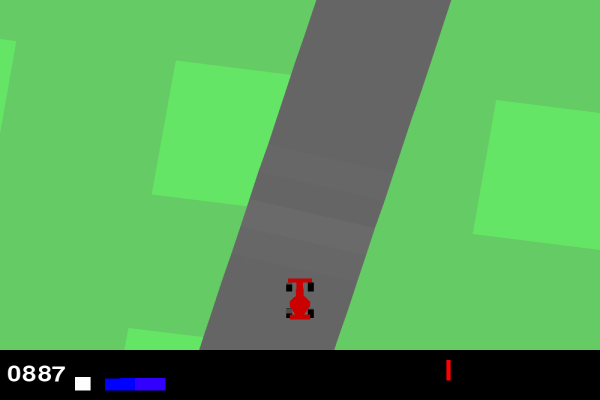

881.0194805194633


In [10]:
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = CarEnvironment(eval_env)
n_actions = eval_env.action_space
agent = DQN(n_actions)
agent.load_model(400)

frames = []
scores = 0
s, _ = eval_env.reset()

eval_env.np_random = np.random.default_rng(42)

done, ret = False, 0

from PIL import Image as PILImage
def render2img(_img): return PILImage.fromarray(_img, "RGB")
handle = display(None, display_id=True)
while not done:
    _render = eval_env.render()
    handle.update(render2img(_render))
    frames.append(_render)
    s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
    a = agent.select_action(s, evaluation_phase=True)
    discrete_action = a.item() % 5
    s_prime, r, terminated, truncated, info = eval_env.step(discrete_action)
    s = s_prime
    ret += r
    done = terminated or truncated
    if terminated:
      print(terminated)
      
scores += ret

print(scores)
def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random

    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()

ValueError: x and y must have same first dimension, but have shapes (899,) and (1000,)

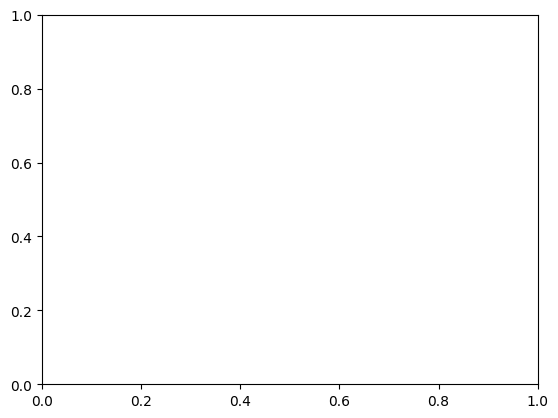

In [10]:
# animate(frames, None)

with open('statistics.pkl', 'rb') as f:
    data_tuple = pickle.load(f)

episode_duration, rewards_per_episode, average_episode_loss = data_tuple

x = [k for k in range(episodes)]

rewards_per_episode = [tensor.cpu() if tensor.is_cuda else tensor for tensor in rewards_per_episode]

plot_statistics(x, episode_duration, "Duration for episode", "Episode", "Duration")
plot_statistics(x, rewards_per_episode, "Rewards for every episode", "Episode", "Reward")
plot_statistics(x, average_episode_loss, "Average loss for every episode", "Episode", "Average Loss")